In [1]:
import pandas as pd
import numpy as np

# Load the dataset
df = pd.read_csv("not_final3.csv")
df = df.rename(columns={'Sport_-1': 'Sport'})

# List of sports to exclude
excluded_sports = ['climbing', 'Fitness', 'Headis']

# Filter out excluded sports
df = df[~df['Sport'].isin(excluded_sports)]

# Define parameters including 'label'
parameters = ['drug', 'equity', 'popularity', 'normalizedcountry', 'CV', 'label']

# Initialize a dictionary to store processed data for each sport
sport_data_dict = {}

for sport_name in df['Sport'].unique():
    sport_dict = {'Year': []}
    
    # Initialize a DataFrame for Year
    all_years = pd.Series(dtype=int)
    
    for parameter in parameters:
        param_columns = [col for col in df.columns if col.startswith(f"{parameter}_")]
        
        if not param_columns:
            continue
        
        # Melt the data for this parameter
        melted_data = df[df['Sport'] == sport_name][['Sport'] + param_columns].melt(
            id_vars='Sport', var_name='Year', value_name=f'{parameter}_Value'
        )
        melted_data['Year'] = melted_data['Year'].str.extract(r'(\d+)').astype(int)  # Extract year as int
        melted_data = melted_data.sort_values('Year')

        if all_years.empty:
            all_years = melted_data['Year']
        else:
            all_years = pd.concat([all_years, melted_data['Year']]).drop_duplicates().sort_values()
        
        # Align parameter data with all years
        melted_data = melted_data.set_index('Year').reindex(all_years).reset_index()
        
        # Handle missing data based on parameter type
        if parameter == 'drug':
            melted_data[f'{parameter}_Value'] = melted_data[f'{parameter}_Value'].fillna(0)  # For drug, fill missing with 0
        elif parameter in ['popularity', 'CV']:
            # For popularity and CV, treat 0 as missing and replace with NaN
            melted_data[f'{parameter}_Value'] = melted_data[f'{parameter}_Value'].replace(0, np.nan)
        else:
            # Preserve NaN for other parameters
            melted_data[f'{parameter}_Value'] = melted_data[f'{parameter}_Value']
        
        # Store parameter values aligned by Year
        sport_dict[parameter] = melted_data[f'{parameter}_Value'].values

    # Ensure that Year is included
    sport_dict['Year'] = all_years.values
    
    # Convert the dictionary to a DataFrame
    sport_data_dict[sport_name] = pd.DataFrame(sport_dict)

# Example usage: print data for a specific sport
for sport, data in sport_data_dict.items():
    data.set_index('Year', inplace=True)  # Ensure Year is the index
    

    print(f"\nData for {sport}:")
    print(data.head())



Data for Alpine Skiing:
      drug  equity  popularity  normalizedcountry  CV  label
Year                                                        
1896   0.0     NaN         NaN                NaN NaN      0
1900   0.0     NaN         NaN                NaN NaN      0
1904   0.0     NaN         NaN                NaN NaN      0
1906   0.0     NaN         NaN                NaN NaN      0
1908   0.0     NaN         NaN                NaN NaN      0

Data for Alpinism:
      drug  equity  popularity  normalizedcountry  CV  label
Year                                                        
1896   0.0     NaN         NaN                NaN NaN      0
1900   0.0     NaN         NaN                NaN NaN      0
1904   0.0     NaN         NaN                NaN NaN      0
1906   0.0     NaN         NaN                NaN NaN      0
1908   0.0     NaN         NaN                NaN NaN      0

Data for Archery:
      drug    equity  popularity  normalizedcountry        CV  label
Year         

In [2]:
sport_data_dict['Alpine Skiing']

,drug,equity,popularity,normalizedcountry,CV,label
Year,,,,,,
1896,0.0,NaN,NaN,NaN,NaN,0
1900,0.0,NaN,NaN,NaN,NaN,0
1904,0.0,NaN,NaN,NaN,NaN,0
1906,0.0,NaN,NaN,NaN,NaN,0
1908,0.0,NaN,NaN,NaN,NaN,0
1912,0.0,NaN,NaN,NaN,NaN,0
1920,0.0,NaN,NaN,NaN,NaN,0
1924,0.0,NaN,NaN,NaN,NaN,0
1928,0.0,NaN,NaN,NaN,NaN,0


In [3]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX

def fill_missing_with_sarimax(df, column, order=(1,1,1), seasonal_order=(0,0,0,0), min_val=None, max_val=None):
    # Ensure 'Year' is in the dataframe and sorted
    if 'Year' not in df.columns:
        df = df.reset_index()

    df = df.sort_values('Year')

    # Ensure 'Year' is a datetime type
    if not np.issubdtype(df['Year'].dtype, np.datetime64):
        df['Year'] = pd.to_datetime(df['Year'], format='%Y')

    # Set 'Year' as index
    df.set_index('Year', inplace=True)

    # Extract the time series
    ts_series = df[column]

    # Initialize a copy of the series to fill missing values
    ts_filled = ts_series.copy()

    # For each time point, if the value is missing, predict it
    for idx in ts_series.index:
        if pd.isna(ts_series.loc[idx]):
            # Use all data up to this point (including previous predictions)
            current_data = ts_filled.loc[:idx].dropna()

            if len(current_data) < 2:
                # Not enough data to train model
                continue

            # Fit SARIMAX model
            try:
                model = SARIMAX(current_data, order=order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
                model_fit = model.fit(disp=False)

                # Predict the next value
                forecast = model_fit.forecast(steps=1)
                prediction = forecast.iloc[0]

                # Clamp predictions within the specified range
                if min_val is not None:
                    prediction = max(prediction, min_val)
                if max_val is not None:
                    prediction = min(prediction, max_val)

                ts_filled.loc[idx] = prediction
            except Exception as e:
                print(f"Error predicting {column} at index {idx}: {e}")
                continue

    # Assign filled series back to dataframe
    df[column] = ts_filled

    # Reset index to have 'Year' as a column
    df.reset_index(inplace=True)

    return df

def fill_continuous_columns_with_sarimax(df):
    for col in ['equity', 'popularity', 'normalizedcountry', 'CV', 'drug']:
        min_val, max_val = None, None
        if col == 'normalizedcountry':
            min_val, max_val = 0.0, 1.0
        elif col == 'equity':
            min_val, max_val = 0.0, 0.5
        elif col == 'popularity':
            min_val, max_val = 0.0, 0.4  # Cap popularity
        elif col == 'CV':
            min_val, max_val = 0.0, 1.5  # Cap CV
        elif col == 'drug':
            min_val, max_val = 0.0, 1.0  # Assuming 'drug' ranges between 0 and 1

        if df[col].notna().sum() < 2:
            print(f"Skipping {col} due to insufficient data.")
            continue

        df = fill_missing_with_sarimax(df, col, min_val=min_val, max_val=max_val)
    return df

# Example Usage for Filling Missing Data
for sport, data in sport_data_dict.items():
    sport_data_dict[sport] = fill_continuous_columns_with_sarimax(data)

# Display the filled DataFrame for Alpine Skiing as an example
print(sport_data_dict['Alpine Skiing'].head(30))


/media/tameszaza/My Passport/ml/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/media/tameszaza/My Passport/ml/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/media/tameszaza/My Passport/ml/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/media/tameszaza/My Passport/ml/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling th

Error predicting equity at index 1906-01-01 00:00:00: too many indices for array: array is 0-dimensional, but 1 were indexed


/media/tameszaza/My Passport/ml/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/media/tameszaza/My Passport/ml/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/media/tameszaza/My Passport/ml/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/media/tameszaza/My Passport/ml/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no asso

Error predicting popularity at index 1906-01-01 00:00:00: too many indices for array: array is 0-dimensional, but 1 were indexed


/media/tameszaza/My Passport/ml/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/media/tameszaza/My Passport/ml/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/media/tameszaza/My Passport/ml/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/media/tameszaza/My Passport/ml/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information

Error predicting normalizedcountry at index 1906-01-01 00:00:00: too many indices for array: array is 0-dimensional, but 1 were indexed
Error predicting CV at index 1906-01-01 00:00:00: too many indices for array: array is 0-dimensional, but 1 were indexed


/media/tameszaza/My Passport/ml/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/media/tameszaza/My Passport/ml/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/media/tameszaza/My Passport/ml/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/media/tameszaza/My Passport/ml/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information

Skipping equity due to insufficient data.
Skipping popularity due to insufficient data.
Skipping normalizedcountry due to insufficient data.
Skipping CV due to insufficient data.


/media/tameszaza/My Passport/ml/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 4YS-JAN will be used.
  self._init_dates(dates, freq)
/media/tameszaza/My Passport/ml/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 4YS-JAN will be used.
  self._init_dates(dates, freq)
/media/tameszaza/My Passport/ml/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 4YS-JAN will be used.
  self._init_dates(dates, freq)
/media/tameszaza/My Passport/ml/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 4YS-JAN will be used.
  self._init_dates(dates, freq)
/media/tameszaza/My Passport/ml/.venv/lib/python3.12/site-pa

Error predicting equity at index 1912-01-01 00:00:00: too many indices for array: array is 0-dimensional, but 1 were indexed
Error predicting popularity at index 1912-01-01 00:00:00: too many indices for array: array is 0-dimensional, but 1 were indexed
Error predicting normalizedcountry at index 1912-01-01 00:00:00: too many indices for array: array is 0-dimensional, but 1 were indexed
Error predicting CV at index 1912-01-01 00:00:00: too many indices for array: array is 0-dimensional, but 1 were indexed
Skipping equity due to insufficient data.
Skipping popularity due to insufficient data.
Skipping normalizedcountry due to insufficient data.
Skipping CV due to insufficient data.
Skipping equity due to insufficient data.
Skipping popularity due to insufficient data.
Skipping normalizedcountry due to insufficient data.
Skipping CV due to insufficient data.


/media/tameszaza/My Passport/ml/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/media/tameszaza/My Passport/ml/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/media/tameszaza/My Passport/ml/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/media/tameszaza/My Passport/ml/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no asso

Skipping equity due to insufficient data.
Skipping popularity due to insufficient data.
Skipping normalizedcountry due to insufficient data.
Skipping CV due to insufficient data.


/media/tameszaza/My Passport/ml/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/media/tameszaza/My Passport/ml/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/media/tameszaza/My Passport/ml/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/media/tameszaza/My Passport/ml/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no asso

Skipping equity due to insufficient data.
Skipping popularity due to insufficient data.
Skipping normalizedcountry due to insufficient data.
Skipping CV due to insufficient data.
Error predicting equity at index 1906-01-01 00:00:00: too many indices for array: array is 0-dimensional, but 1 were indexed
Error predicting equity at index 1908-01-01 00:00:00: too many indices for array: array is 0-dimensional, but 1 were indexed
Error predicting equity at index 1912-01-01 00:00:00: too many indices for array: array is 0-dimensional, but 1 were indexed
Error predicting equity at index 1920-01-01 00:00:00: too many indices for array: array is 0-dimensional, but 1 were indexed
Error predicting equity at index 1924-01-01 00:00:00: too many indices for array: array is 0-dimensional, but 1 were indexed
Error predicting equity at index 1928-01-01 00:00:00: too many indices for array: array is 0-dimensional, but 1 were indexed
Error predicting equity at index 1932-01-01 00:00:00: too many indices 

/media/tameszaza/My Passport/ml/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/media/tameszaza/My Passport/ml/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/media/tameszaza/My Passport/ml/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/media/tameszaza/My Passport/ml/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no asso

Skipping equity due to insufficient data.
Skipping popularity due to insufficient data.
Skipping normalizedcountry due to insufficient data.
Skipping CV due to insufficient data.
Error predicting equity at index 1912-01-01 00:00:00: too many indices for array: array is 0-dimensional, but 1 were indexed
Error predicting equity at index 1920-01-01 00:00:00: too many indices for array: array is 0-dimensional, but 1 were indexed
Error predicting equity at index 1924-01-01 00:00:00: too many indices for array: array is 0-dimensional, but 1 were indexed
Error predicting equity at index 1928-01-01 00:00:00: too many indices for array: array is 0-dimensional, but 1 were indexed
Error predicting equity at index 1932-01-01 00:00:00: too many indices for array: array is 0-dimensional, but 1 were indexed
Error predicting equity at index 1936-01-01 00:00:00: too many indices for array: array is 0-dimensional, but 1 were indexed
Error predicting equity at index 1948-01-01 00:00:00: too many indices 

/media/tameszaza/My Passport/ml/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/media/tameszaza/My Passport/ml/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/media/tameszaza/My Passport/ml/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/media/tameszaza/My Passport/ml/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no asso

Skipping equity due to insufficient data.
Skipping popularity due to insufficient data.
Skipping normalizedcountry due to insufficient data.
Skipping CV due to insufficient data.
Skipping equity due to insufficient data.
Skipping popularity due to insufficient data.
Skipping normalizedcountry due to insufficient data.
Skipping CV due to insufficient data.


/media/tameszaza/My Passport/ml/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/media/tameszaza/My Passport/ml/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/media/tameszaza/My Passport/ml/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/media/tameszaza/My Passport/ml/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information

Error predicting equity at index 1912-01-01 00:00:00: too many indices for array: array is 0-dimensional, but 1 were indexed


/media/tameszaza/My Passport/ml/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/media/tameszaza/My Passport/ml/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/media/tameszaza/My Passport/ml/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/media/tameszaza/My Passport/ml/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information

Error predicting popularity at index 1912-01-01 00:00:00: too many indices for array: array is 0-dimensional, but 1 were indexed


/media/tameszaza/My Passport/ml/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/media/tameszaza/My Passport/ml/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/media/tameszaza/My Passport/ml/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/media/tameszaza/My Passport/ml/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information

Error predicting normalizedcountry at index 1912-01-01 00:00:00: too many indices for array: array is 0-dimensional, but 1 were indexed


/media/tameszaza/My Passport/ml/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/media/tameszaza/My Passport/ml/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/media/tameszaza/My Passport/ml/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/media/tameszaza/My Passport/ml/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no asso

Error predicting CV at index 1912-01-01 00:00:00: too many indices for array: array is 0-dimensional, but 1 were indexed


/media/tameszaza/My Passport/ml/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/media/tameszaza/My Passport/ml/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/media/tameszaza/My Passport/ml/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/media/tameszaza/My Passport/ml/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information

Skipping equity due to insufficient data.
Skipping popularity due to insufficient data.
Skipping normalizedcountry due to insufficient data.
Skipping CV due to insufficient data.
Skipping equity due to insufficient data.
Skipping popularity due to insufficient data.
Skipping normalizedcountry due to insufficient data.
Skipping CV due to insufficient data.


/media/tameszaza/My Passport/ml/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 4YS-JAN will be used.
  self._init_dates(dates, freq)
/media/tameszaza/My Passport/ml/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 4YS-JAN will be used.
  self._init_dates(dates, freq)
/media/tameszaza/My Passport/ml/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 4YS-JAN will be used.
  self._init_dates(dates, freq)
/media/tameszaza/My Passport/ml/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 4YS-JAN will be used.
  self._init_dates(dates, freq)
/media/tameszaza/My Passport/ml/.venv/lib/python3.12/site-pa

Error predicting equity at index 1912-01-01 00:00:00: too many indices for array: array is 0-dimensional, but 1 were indexed


/media/tameszaza/My Passport/ml/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/media/tameszaza/My Passport/ml/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/media/tameszaza/My Passport/ml/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/media/tameszaza/My Passport/ml/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information

Error predicting popularity at index 1912-01-01 00:00:00: too many indices for array: array is 0-dimensional, but 1 were indexed


/media/tameszaza/My Passport/ml/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/media/tameszaza/My Passport/ml/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/media/tameszaza/My Passport/ml/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/media/tameszaza/My Passport/ml/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no asso

Error predicting normalizedcountry at index 1912-01-01 00:00:00: too many indices for array: array is 0-dimensional, but 1 were indexed


/media/tameszaza/My Passport/ml/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/media/tameszaza/My Passport/ml/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/media/tameszaza/My Passport/ml/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/media/tameszaza/My Passport/ml/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no asso

Error predicting CV at index 1912-01-01 00:00:00: too many indices for array: array is 0-dimensional, but 1 were indexed


/media/tameszaza/My Passport/ml/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/media/tameszaza/My Passport/ml/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/media/tameszaza/My Passport/ml/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/media/tameszaza/My Passport/ml/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information

Skipping normalizedcountry due to insufficient data.
Skipping CV due to insufficient data.
Error predicting equity at index 1904-01-01 00:00:00: too many indices for array: array is 0-dimensional, but 1 were indexed
Error predicting popularity at index 1904-01-01 00:00:00: too many indices for array: array is 0-dimensional, but 1 were indexed
Error predicting normalizedcountry at index 1904-01-01 00:00:00: too many indices for array: array is 0-dimensional, but 1 were indexed
Error predicting CV at index 1904-01-01 00:00:00: too many indices for array: array is 0-dimensional, but 1 were indexed
Skipping equity due to insufficient data.
Skipping popularity due to insufficient data.
Skipping normalizedcountry due to insufficient data.
Skipping CV due to insufficient data.
Error predicting equity at index 1952-01-01 00:00:00: too many indices for array: array is 0-dimensional, but 1 were indexed
Error predicting equity at index 1956-01-01 00:00:00: too many indices for array: array is 0-d

/media/tameszaza/My Passport/ml/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/media/tameszaza/My Passport/ml/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/media/tameszaza/My Passport/ml/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/media/tameszaza/My Passport/ml/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no asso

Error predicting equity at index 2020-01-01 00:00:00: too many indices for array: array is 0-dimensional, but 1 were indexed
Error predicting equity at index 2024-01-01 00:00:00: too many indices for array: array is 0-dimensional, but 1 were indexed
Error predicting popularity at index 1952-01-01 00:00:00: too many indices for array: array is 0-dimensional, but 1 were indexed
Error predicting popularity at index 1956-01-01 00:00:00: too many indices for array: array is 0-dimensional, but 1 were indexed
Error predicting popularity at index 1960-01-01 00:00:00: too many indices for array: array is 0-dimensional, but 1 were indexed
Error predicting popularity at index 1964-01-01 00:00:00: too many indices for array: array is 0-dimensional, but 1 were indexed
Error predicting popularity at index 1968-01-01 00:00:00: too many indices for array: array is 0-dimensional, but 1 were indexed
Error predicting popularity at index 1972-01-01 00:00:00: too many indices for array: array is 0-dimensio

/media/tameszaza/My Passport/ml/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/media/tameszaza/My Passport/ml/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/media/tameszaza/My Passport/ml/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/media/tameszaza/My Passport/ml/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no asso

Skipping equity due to insufficient data.
Skipping popularity due to insufficient data.
Skipping normalizedcountry due to insufficient data.
Skipping CV due to insufficient data.


/media/tameszaza/My Passport/ml/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 4YS-JAN will be used.
  self._init_dates(dates, freq)
/media/tameszaza/My Passport/ml/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 4YS-JAN will be used.
  self._init_dates(dates, freq)
/media/tameszaza/My Passport/ml/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/media/tameszaza/My Passport/ml/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 4YS-JAN will be used.
  self._init_dates(dates, freq)
/media/tameszaza/My Passport/ml/.venv/lib/pyth

Error predicting equity at index 1906-01-01 00:00:00: too many indices for array: array is 0-dimensional, but 1 were indexed
Error predicting popularity at index 1906-01-01 00:00:00: too many indices for array: array is 0-dimensional, but 1 were indexed
Error predicting normalizedcountry at index 1906-01-01 00:00:00: too many indices for array: array is 0-dimensional, but 1 were indexed
Error predicting CV at index 1906-01-01 00:00:00: too many indices for array: array is 0-dimensional, but 1 were indexed


/media/tameszaza/My Passport/ml/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/media/tameszaza/My Passport/ml/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/media/tameszaza/My Passport/ml/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/media/tameszaza/My Passport/ml/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no asso

         Year  drug    equity  popularity  normalizedcountry        CV  label
0  1896-01-01   0.0       NaN         NaN                NaN       NaN      0
1  1900-01-01   0.0       NaN         NaN                NaN       NaN      0
2  1904-01-01   0.0       NaN         NaN                NaN       NaN      0
3  1906-01-01   0.0       NaN         NaN                NaN       NaN      0
4  1908-01-01   0.0       NaN         NaN                NaN       NaN      0
5  1912-01-01   0.0       NaN         NaN                NaN       NaN      0
6  1920-01-01   0.0       NaN         NaN                NaN       NaN      0
7  1924-01-01   0.0       NaN         NaN                NaN       NaN      0
8  1928-01-01   0.0       NaN         NaN                NaN       NaN      0
9  1932-01-01   0.0       NaN         NaN                NaN       NaN      0
10 1936-01-01   0.0  0.359223    0.013919           0.130000  0.870456      1
11 1948-01-01   0.0  0.258333    0.048128           0.125000  0.

/media/tameszaza/My Passport/ml/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/media/tameszaza/My Passport/ml/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/media/tameszaza/My Passport/ml/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/media/tameszaza/My Passport/ml/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no asso

In [4]:
import pandas as pd

# Initialize an empty list to store each sport's data
all_sports_data = []

# Iterate over the sport_data_dict to process each sport's DataFrame
for sport, df in sport_data_dict.items():
    df = df.reset_index()  # Ensure 'Year' is a column, not an index
    df['Sport'] = sport  # Add a new column to indicate the sport name
    all_sports_data.append(df)  # Append the DataFrame to the list

# Concatenate all DataFrames in the list into a single DataFrame
combined_sport_data = pd.concat(all_sports_data, ignore_index=True)

# Display the first few rows of the combined DataFrame
combined_sport_data


,index,Year,drug,equity,popularity,normalizedcountry,CV,label,Sport
0,0,1896-01-01,0.0,NaN,NaN,NaN,NaN,0,Alpine Skiing
1,1,1900-01-01,0.0,NaN,NaN,NaN,NaN,0,Alpine Skiing
2,2,1904-01-01,0.0,NaN,NaN,NaN,NaN,0,Alpine Skiing
3,3,1906-01-01,0.0,NaN,NaN,NaN,NaN,0,Alpine Skiing
4,4,1908-01-01,0.0,NaN,NaN,NaN,NaN,0,Alpine Skiing
...,...,...,...,...,...,...,...,...,...
2010,26,2008-01-01,7.0,0.192420,0.025217,0.295000,0.722179,1,Wrestling
2011,27,2012-01-01,4.0,0.224189,0.026238,0.350000,0.767672,1,Wrestling
2012,28,2016-01-01,1.0,0.323699,0.025278,0.330000,0.709537,1,Wrestling
2013,29,2020-01-01,0.0,0.333333,0.027252,0.354208,0.791572,1,Wrestling


In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Load the data
df = pd.read_csv('not_final3.csv')

# Select specific columns by their names
selected_columns = df[['Sport_-1', 'estimate per event_2024']]
selected_columns = selected_columns.drop([65, 66, 67])
selected_columns = selected_columns.rename(columns={'estimate per event_2024': 'sustain', 'Sport_-1': 'Sport'})

# Apply log scale normalization to the sustain column
selected_columns['sustain'] = np.log1p(selected_columns['sustain'])

# Apply Min-Max normalization
#scaler = MinMaxScaler()
#selected_columns['sustain'] = scaler.fit_transform(selected_columns[['sustain']])

# Display the normalized data
print(selected_columns)


               Sport   sustain
0      Alpine Skiing  7.601402
1           Alpinism  6.216606
2            Archery  4.615121
3   Art Competitions  0.000000
4          Athletics  8.922792
..               ...       ...
60        Tug-Of-War  4.330733
61        Volleyball  6.478510
62        Water Polo  7.048386
63     Weightlifting  5.707110
64         Wrestling  5.860786

[65 rows x 2 columns]


In [6]:
sport_data_dict['Alpine Skiing']

,Year,drug,equity,popularity,normalizedcountry,CV,label
0,1896-01-01,0.0,NaN,NaN,NaN,NaN,0
1,1900-01-01,0.0,NaN,NaN,NaN,NaN,0
2,1904-01-01,0.0,NaN,NaN,NaN,NaN,0
3,1906-01-01,0.0,NaN,NaN,NaN,NaN,0
4,1908-01-01,0.0,NaN,NaN,NaN,NaN,0
5,1912-01-01,0.0,NaN,NaN,NaN,NaN,0
6,1920-01-01,0.0,NaN,NaN,NaN,NaN,0
7,1924-01-01,0.0,NaN,NaN,NaN,NaN,0
8,1928-01-01,0.0,NaN,NaN,NaN,NaN,0
9,1932-01-01,0.0,NaN,NaN,NaN,NaN,0


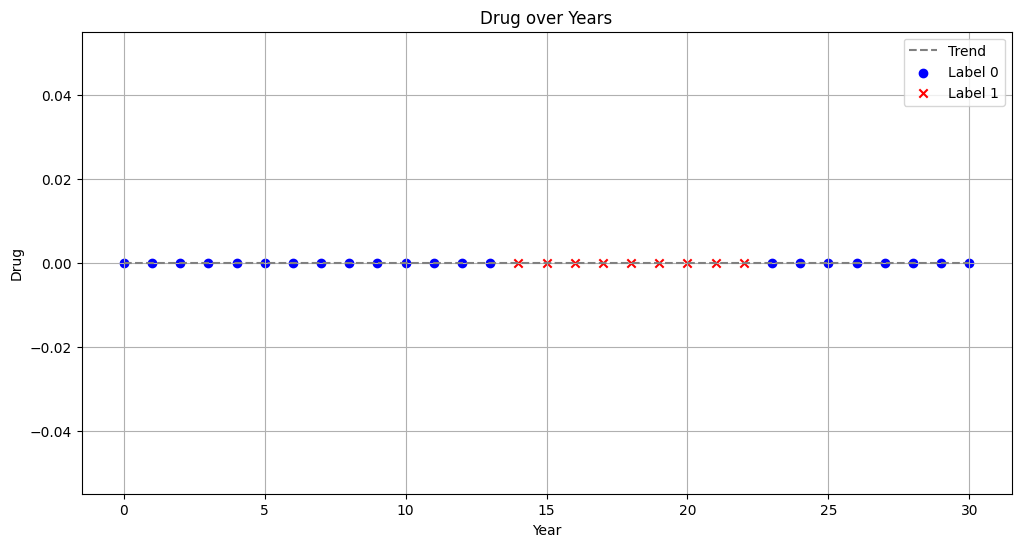

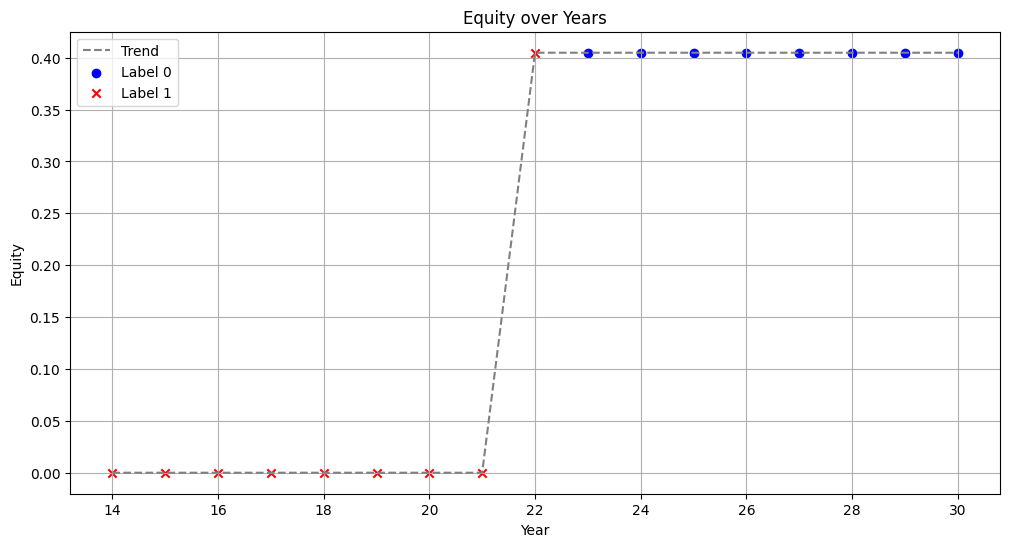

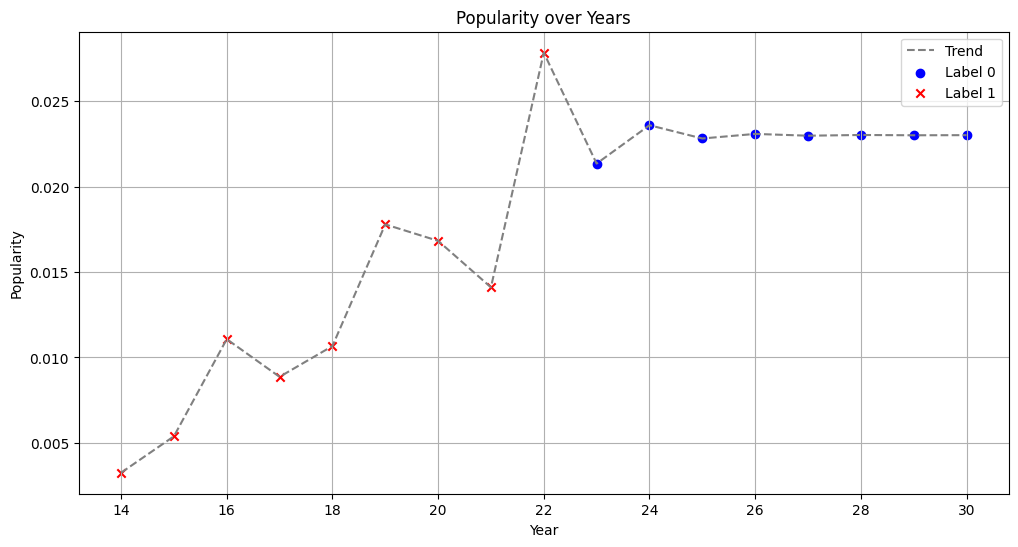

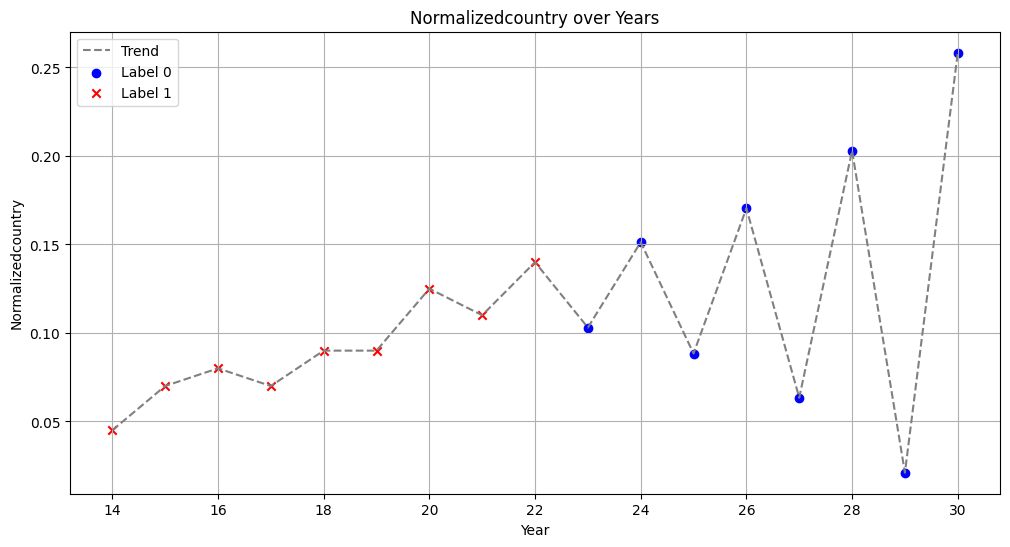

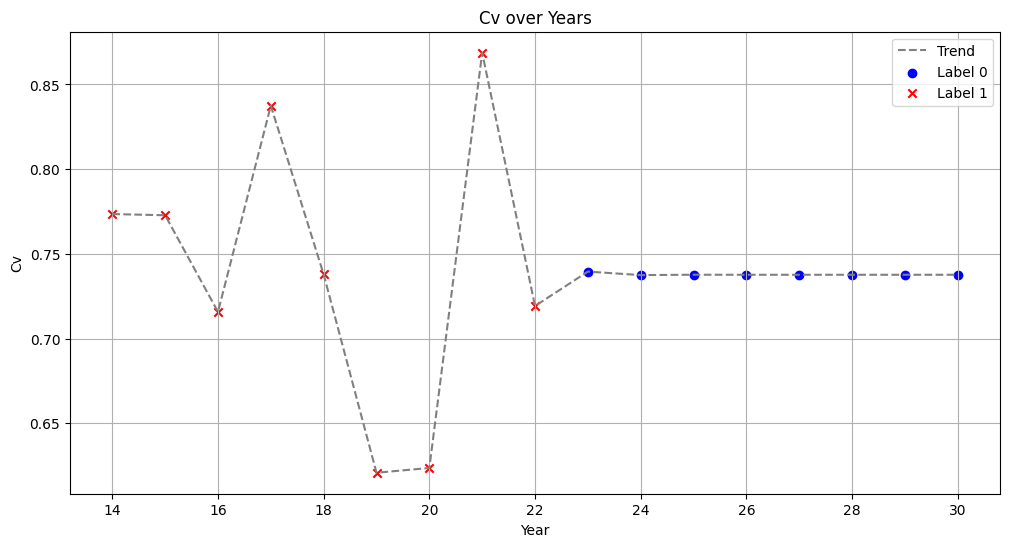

In [7]:
import matplotlib.pyplot as plt

def plot_data_with_labels(data):
    """
    Plot data with distinct colors for points where label is 1 or 0.

    Parameters:
    data (pd.DataFrame): DataFrame containing the columns: 'drug', 'equity', 'popularity', 
                         'normalizedcountry', 'CV', 'label' with 'Year' as the index.
    """
    # Filter data based on labels
    label_0 = data[data['label'] == 0]
    label_1 = data[data['label'] == 1]

    # Plot each parameter
    parameters = ['drug', 'equity', 'popularity', 'normalizedcountry', 'CV']
    for param in parameters:
        plt.figure(figsize=(12, 6))
        plt.plot(data.index, data[param], color='gray', label='Trend', linestyle='--')
        
        # Scatter plot for label 0
        plt.scatter(label_0.index, label_0[param], color='blue', label='Label 0', marker='o')
        
        # Scatter plot for label 1
        plt.scatter(label_1.index, label_1[param], color='red', label='Label 1', marker='x')
        
        # Add labels and title
        plt.title(f"{param.capitalize()} over Years")
        plt.xlabel("Year")
        plt.ylabel(param.capitalize())
        plt.legend()
        plt.grid(True)
        
        # Save or show the plot
        plt.show()

# Assuming data is in a pandas DataFrame named df
# plot_data_with_labels(df)
plot_data_with_labels(sport_data_dict['Biathlon'])

In [8]:
import pandas as pd

# Initialize an empty list to store each sport's data
all_sports_data = []

# Iterate over the sport_data_dict to process each sport's DataFrame
for sport, df in sport_data_dict.items():
    df = df.reset_index()  # Ensure 'Year' is a column, not an index
    df['Sport'] = sport  # Add a new column to indicate the sport name
    all_sports_data.append(df)  # Append the DataFrame to the list

# Concatenate all DataFrames in the list into a single DataFrame
combined_sport_data = pd.concat(all_sports_data, ignore_index=True)
# Assuming df is your DataFrame
combined_sport_data = combined_sport_data.drop(columns='index')  # Remove the 'index' column

# Extract only the year from the 'Year' column
combined_sport_data['Year'] = pd.to_datetime(combined_sport_data['Year']).dt.year
# Display the first few rows of the combined DataFrame
combined_sport_data


,Year,drug,equity,popularity,normalizedcountry,CV,label,Sport
0,1896,0.0,NaN,NaN,NaN,NaN,0,Alpine Skiing
1,1900,0.0,NaN,NaN,NaN,NaN,0,Alpine Skiing
2,1904,0.0,NaN,NaN,NaN,NaN,0,Alpine Skiing
3,1906,0.0,NaN,NaN,NaN,NaN,0,Alpine Skiing
4,1908,0.0,NaN,NaN,NaN,NaN,0,Alpine Skiing
...,...,...,...,...,...,...,...,...
2010,2008,7.0,0.192420,0.025217,0.295000,0.722179,1,Wrestling
2011,2012,4.0,0.224189,0.026238,0.350000,0.767672,1,Wrestling
2012,2016,1.0,0.323699,0.025278,0.330000,0.709537,1,Wrestling
2013,2020,0.0,0.333333,0.027252,0.354208,0.791572,1,Wrestling


In [9]:
# Merge the DataFrames on the 'Sport' column
merged_df2 = combined_sport_data.merge(selected_columns, on='Sport', how='left').dropna()
merged_df = merged_df2
merged_df3 = merged_df
# Display the resulting DataFrame
merged_df2 = merged_df2.drop(columns=['Sport'])
merged_df

,Year,drug,equity,popularity,normalizedcountry,CV,label,Sport,sustain
10,1936,0.0,0.359223,0.013919,0.130000,0.870456,1,Alpine Skiing,7.601402
11,1948,0.0,0.258333,0.048128,0.125000,0.898061,1,Alpine Skiing,7.601402
12,1952,0.0,0.335979,0.040393,0.140000,0.818058,1,Alpine Skiing,7.601402
13,1956,0.0,0.357320,0.062636,0.145000,0.953060,1,Alpine Skiing,7.601402
14,1960,0.0,0.403125,0.034651,0.110000,0.668501,1,Alpine Skiing,7.601402
...,...,...,...,...,...,...,...,...,...
2010,2008,7.0,0.192420,0.025217,0.295000,0.722179,1,Wrestling,5.860786
2011,2012,4.0,0.224189,0.026238,0.350000,0.767672,1,Wrestling,5.860786
2012,2016,1.0,0.323699,0.025278,0.330000,0.709537,1,Wrestling,5.860786
2013,2020,0.0,0.333333,0.027252,0.354208,0.791572,1,Wrestling,5.860786


In [10]:
# Filter data for normal class
normal_class_data = merged_df[merged_df['label'] == 1].drop(columns=['label', 'Sport'])


In [11]:
merged_df = normal_class_data# Check basic information
print(merged_df.info())

# Display the first few rows
print(merged_df.head())

# Summary statistics
print(merged_df.describe())


<class 'pandas.core.frame.DataFrame'>
Index: 880 entries, 10 to 2014
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Year               880 non-null    int32  
 1   drug               880 non-null    float64
 2   equity             880 non-null    float64
 3   popularity         880 non-null    float64
 4   normalizedcountry  880 non-null    float64
 5   CV                 880 non-null    float64
 6   sustain            880 non-null    float64
dtypes: float64(6), int32(1)
memory usage: 51.6 KB
None
    Year  drug    equity  popularity  normalizedcountry        CV   sustain
10  1936   0.0  0.359223    0.013919              0.130  0.870456  7.601402
11  1948   0.0  0.258333    0.048128              0.125  0.898061  7.601402
12  1952   0.0  0.335979    0.040393              0.140  0.818058  7.601402
13  1956   0.0  0.357320    0.062636              0.145  0.953060  7.601402
14  1960   0.0  0.403125    0.0

In [12]:
merged_df = normal_class_data

# EDA

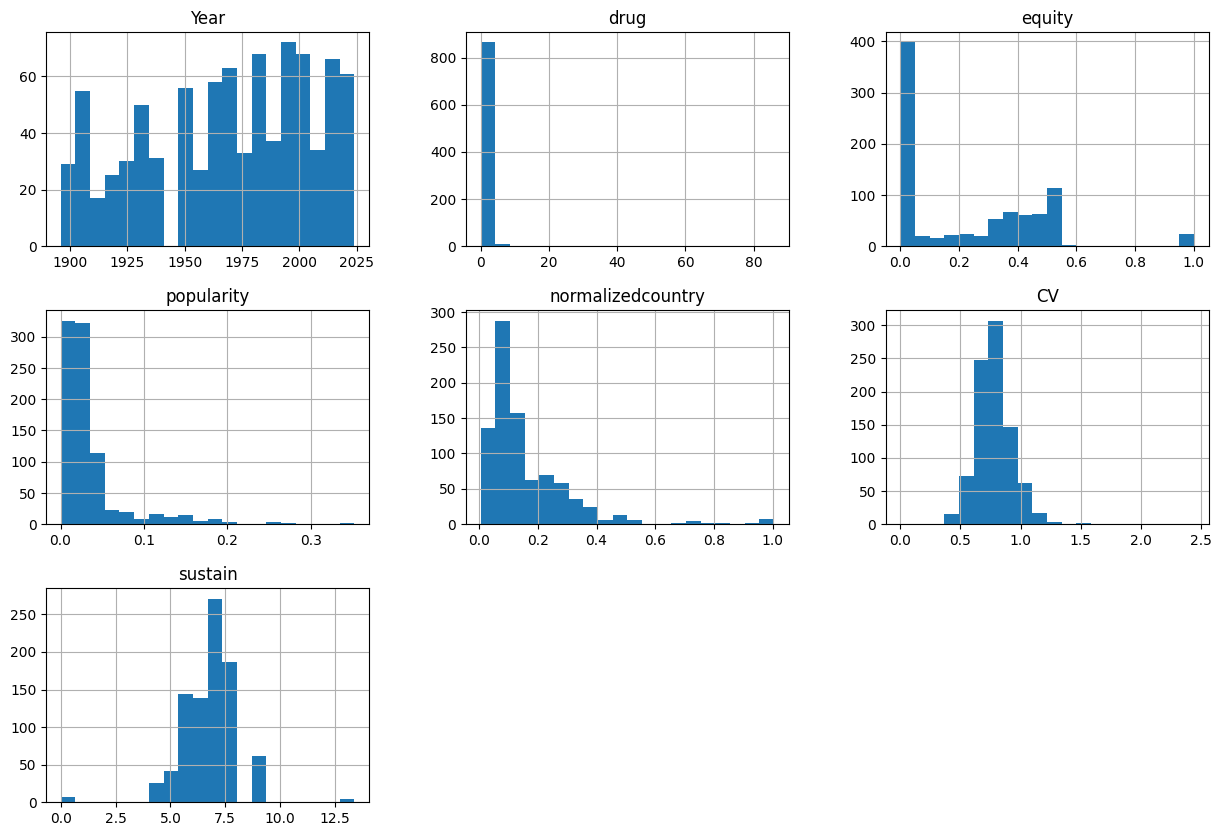

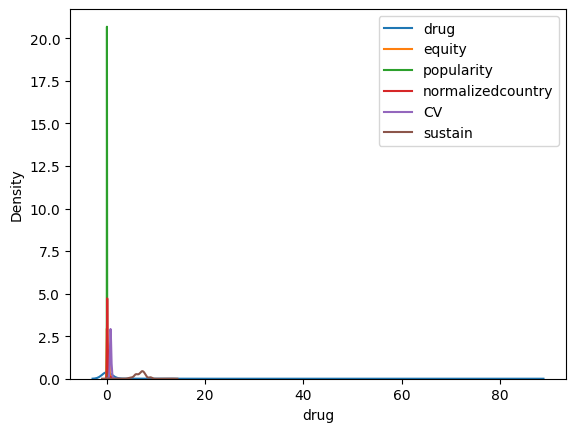

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot histograms for numerical columns
merged_df.hist(bins=20, figsize=(15, 10))
plt.show()

# KDE plots for each column
for column in merged_df.select_dtypes(include=['float64', 'int64']).columns:
    sns.kdeplot(merged_df[column], label=column)
plt.legend()
plt.show()


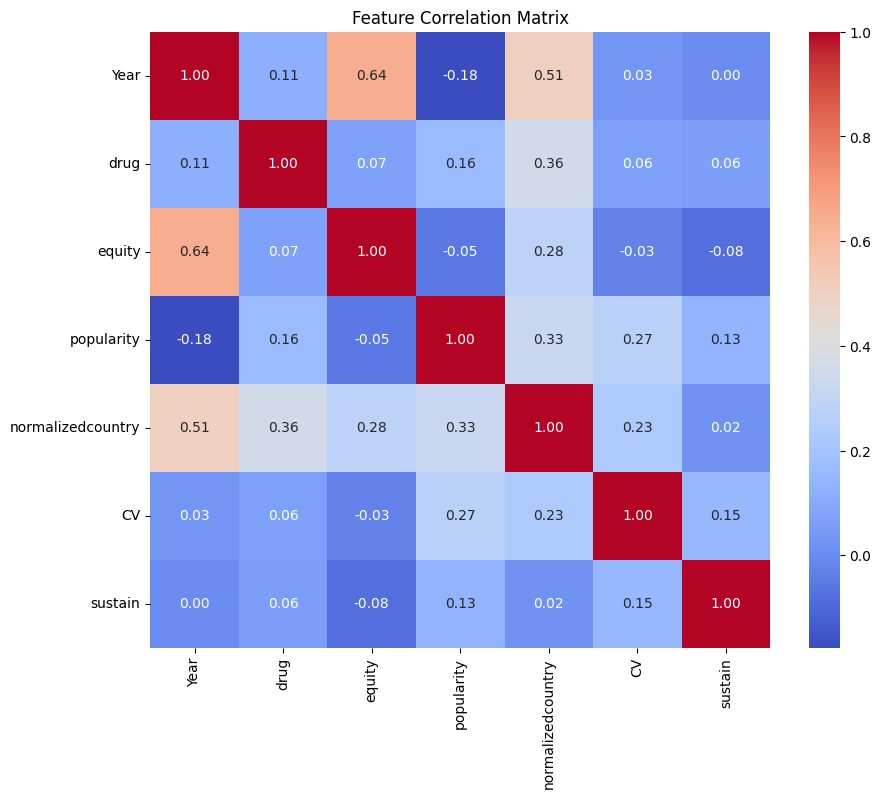

In [14]:
# Correlation matrix
corr_matrix = merged_df.corr()

# Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation Matrix')
plt.show()


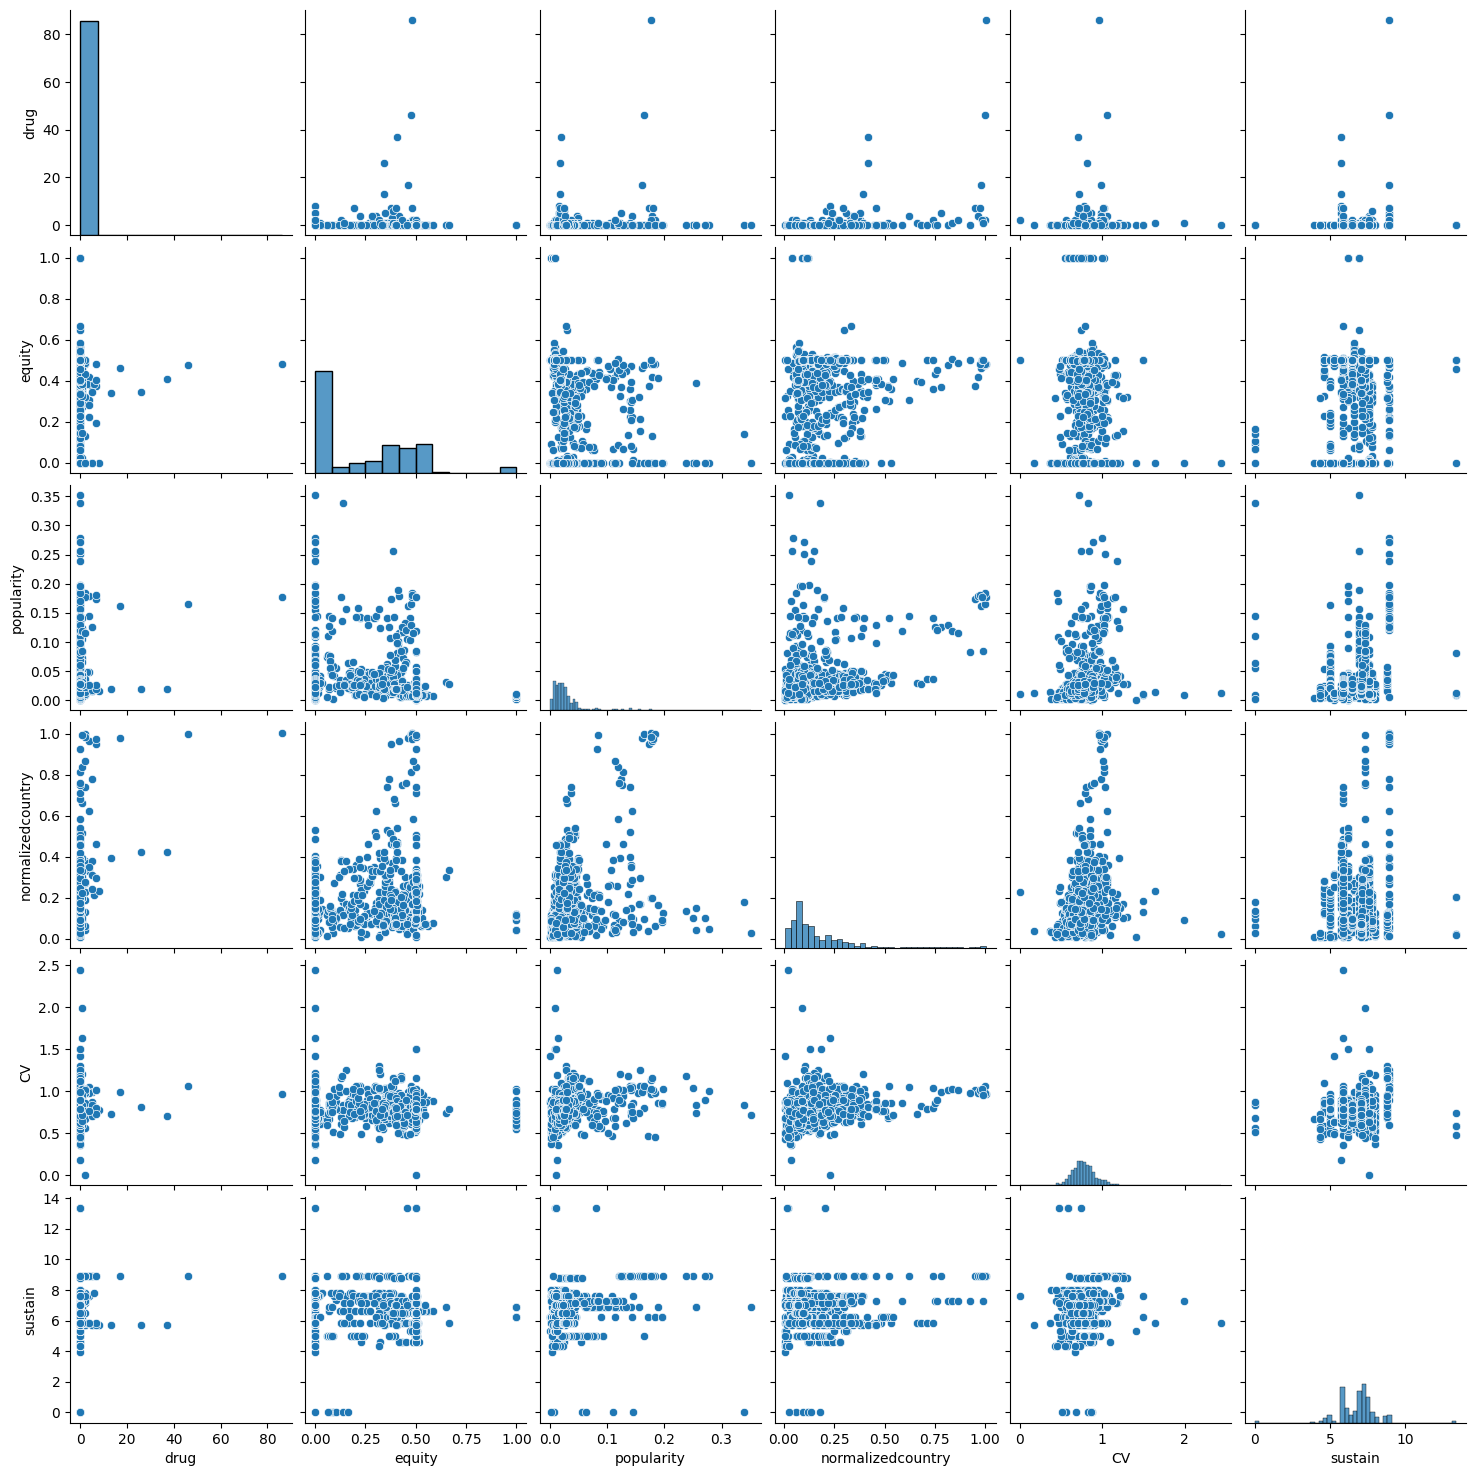

In [15]:
sns.pairplot(merged_df.select_dtypes(include=['float64', 'int64']))
plt.show()


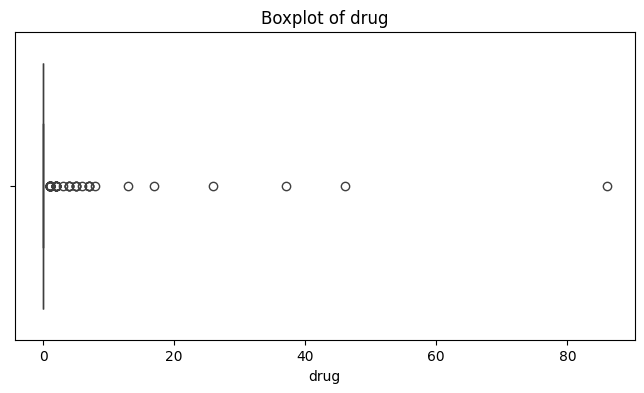

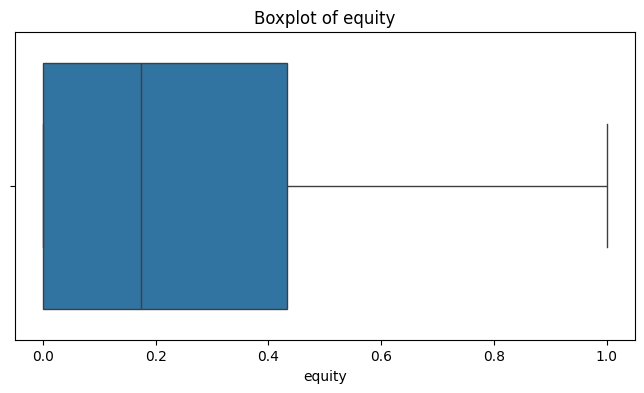

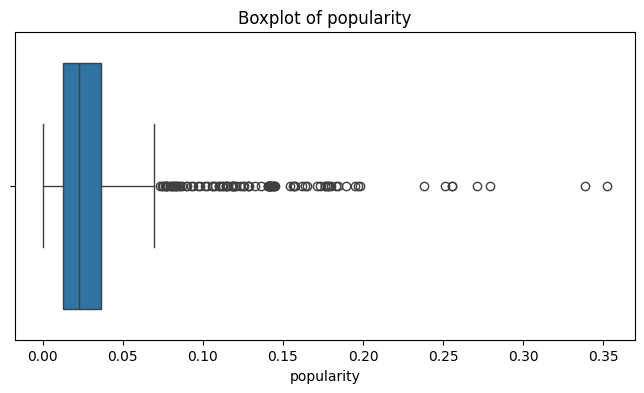

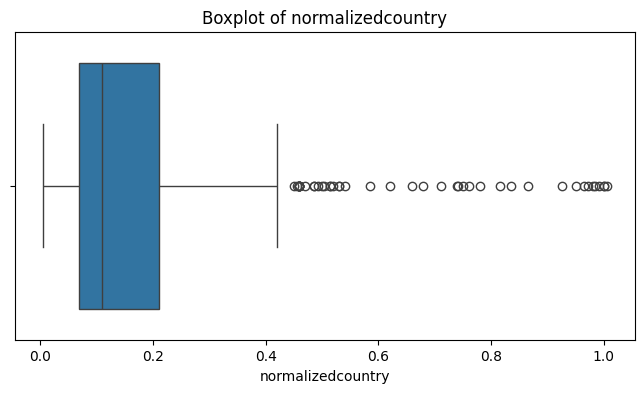

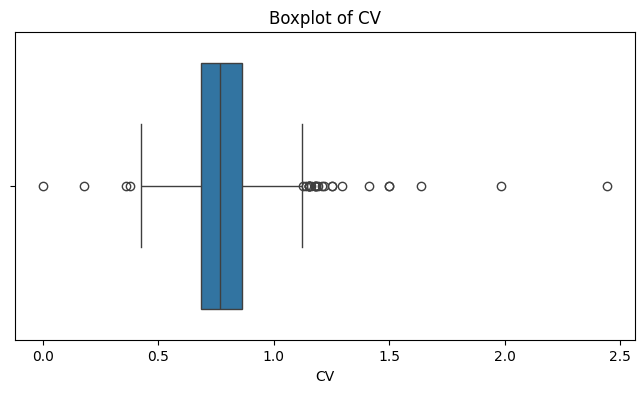

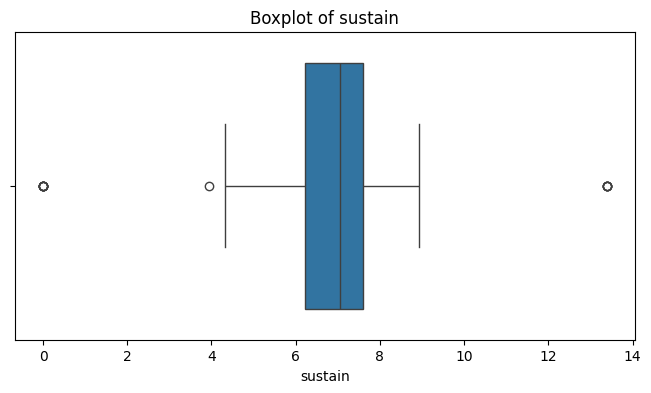

In [16]:
# Boxplot for each numeric feature
for column in merged_df.select_dtypes(include=['float64', 'int64']).columns:
    plt.figure(figsize=(8, 4))
    sns.boxplot(data=merged_df, x=column)
    plt.title(f'Boxplot of {column}')
    plt.show()


In [17]:
merged_df2.describe()

,Year,drug,equity,popularity,normalizedcountry,CV,label,sustain
count,1110.000000,1110.000000,1110.000000,1110.000000,1110.000000,1110.000000,1110.000000,1110.000000
mean,1972.884685,0.333333,0.216738,0.032959,0.150190,0.777522,0.792793,6.711835
std,36.241242,3.350930,0.238725,0.041031,0.166184,0.173794,0.405488,1.522367
min,1896.000000,0.000000,0.000000,0.000270,0.000000,0.000000,0.000000,0.000000
25%,1948.000000,0.000000,0.000000,0.010474,0.060000,0.675824,1.000000,6.216606
50%,1980.000000,0.000000,0.131554,0.020675,0.100000,0.775141,1.000000,7.048386
75%,2004.000000,0.000000,0.427967,0.036288,0.196345,0.866025,1.000000,7.601402
max,2024.000000,86.000000,1.000000,0.352037,1.005000,2.442317,1.000000,13.384729


In [18]:
merged_df2

,Year,drug,equity,popularity,normalizedcountry,CV,label,sustain
10,1936,0.0,0.359223,0.013919,0.130000,0.870456,1,7.601402
11,1948,0.0,0.258333,0.048128,0.125000,0.898061,1,7.601402
12,1952,0.0,0.335979,0.040393,0.140000,0.818058,1,7.601402
13,1956,0.0,0.357320,0.062636,0.145000,0.953060,1,7.601402
14,1960,0.0,0.403125,0.034651,0.110000,0.668501,1,7.601402
...,...,...,...,...,...,...,...,...
2010,2008,7.0,0.192420,0.025217,0.295000,0.722179,1,5.860786
2011,2012,4.0,0.224189,0.026238,0.350000,0.767672,1,5.860786
2012,2016,1.0,0.323699,0.025278,0.330000,0.709537,1,5.860786
2013,2020,0.0,0.333333,0.027252,0.354208,0.791572,1,5.860786


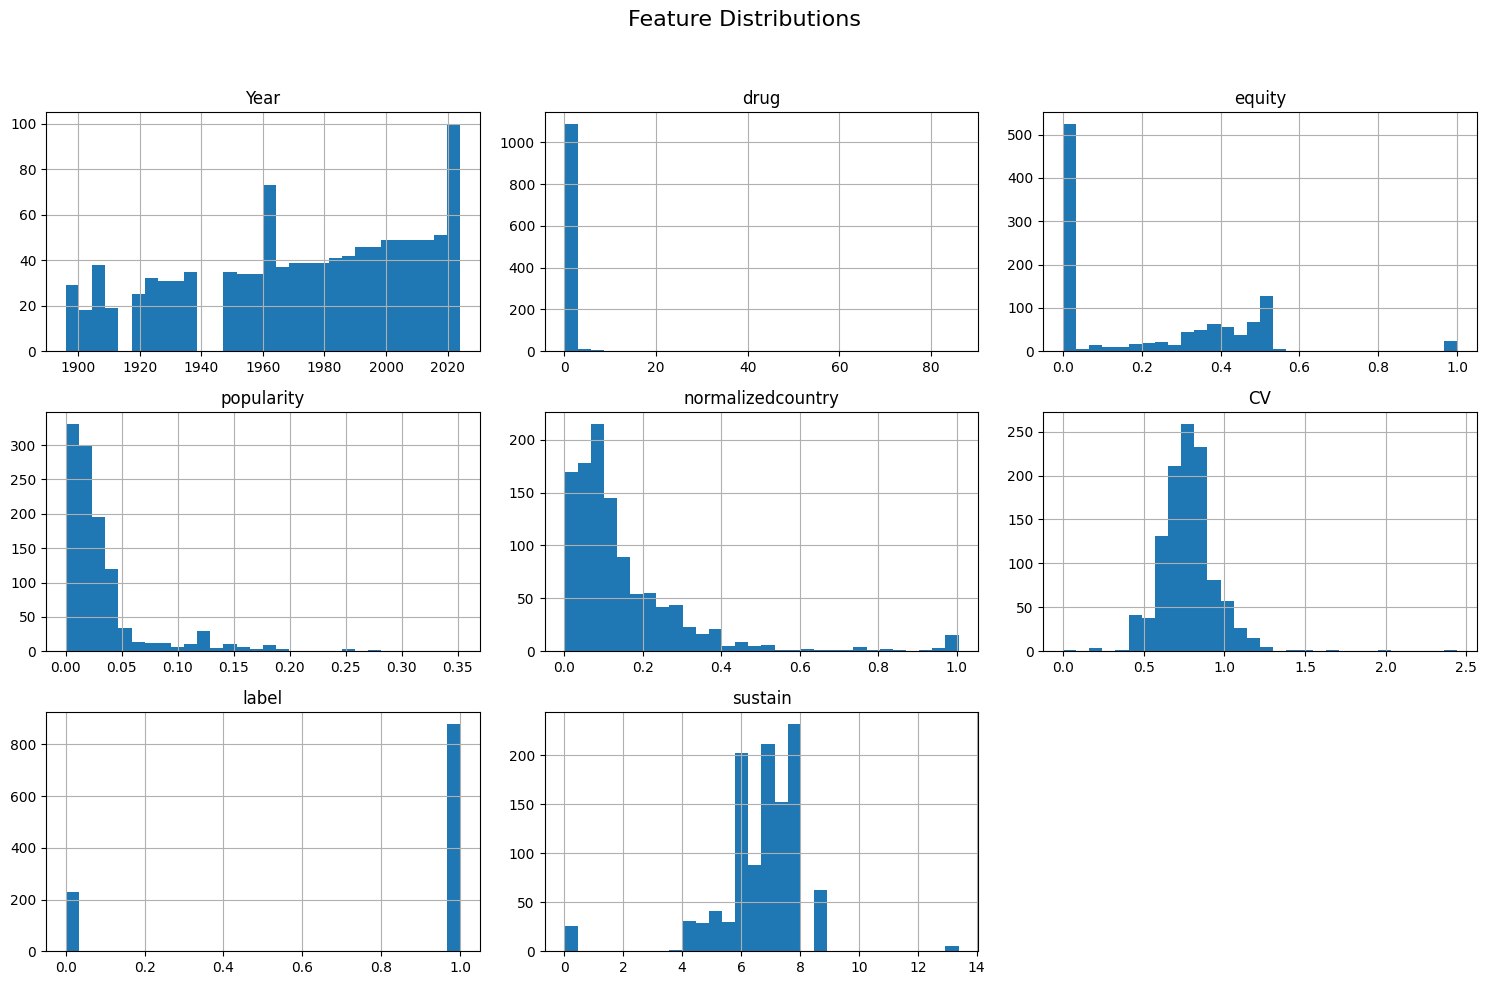

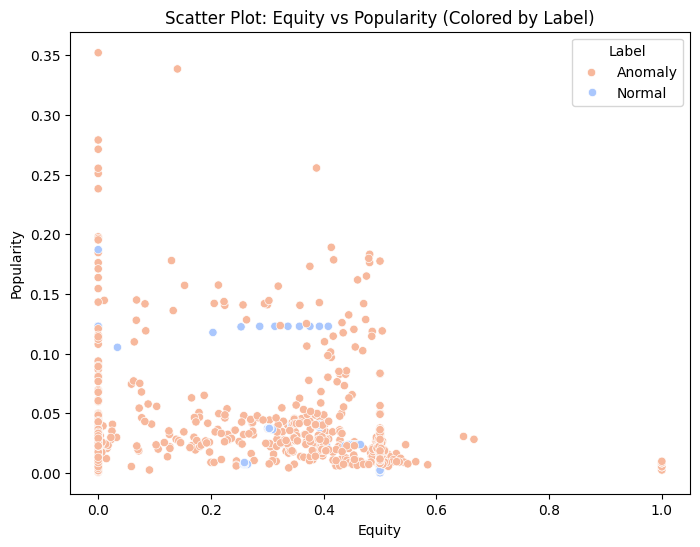

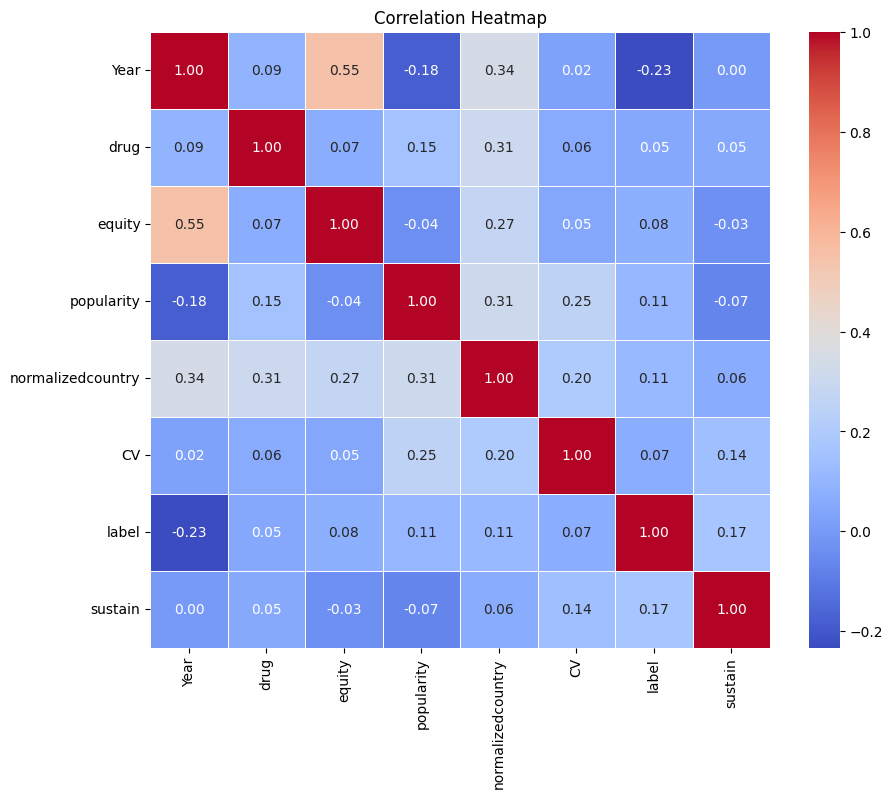

/tmp/ipykernel_20957/1188648840.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df2, x='label', palette='coolwarm')


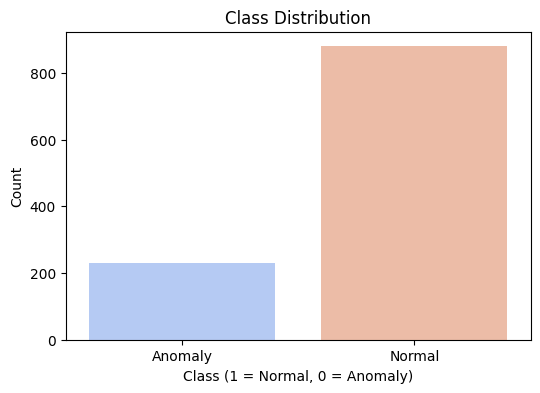

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load merged_df2
df2 = merged_df2.copy()

# 1. Feature distribution (Histogram)
df2.hist(bins=30, figsize=(15, 10), layout=(3, 3))
plt.suptitle("Feature Distributions", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# 2. Scatter plot of two features
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df2, x='equity', y='popularity', hue='label', palette='coolwarm')
plt.title("Scatter Plot: Equity vs Popularity (Colored by Label)")
plt.xlabel("Equity")
plt.ylabel("Popularity")
plt.legend(title="Label", labels=["Anomaly", "Normal"])
plt.show()

# 3. Correlation Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df2.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

# 4. Class Distribution Bar Plot
plt.figure(figsize=(6, 4))
sns.countplot(data=df2, x='label', palette='coolwarm')
plt.title("Class Distribution")
plt.xlabel("Class (1 = Normal, 0 = Anomaly)")
plt.ylabel("Count")
plt.xticks(ticks=[0, 1], labels=["Anomaly", "Normal"])
plt.show()


In [20]:
# Load and prepare data
X = df2.drop(columns=['label'])
y = df2['label']

# Model training

In [22]:
X

,Year,drug,equity,popularity,normalizedcountry,CV,sustain
10,1936,0.0,0.359223,0.013919,0.130000,0.870456,7.601402
11,1948,0.0,0.258333,0.048128,0.125000,0.898061,7.601402
12,1952,0.0,0.335979,0.040393,0.140000,0.818058,7.601402
13,1956,0.0,0.357320,0.062636,0.145000,0.953060,7.601402
14,1960,0.0,0.403125,0.034651,0.110000,0.668501,7.601402
...,...,...,...,...,...,...,...
2010,2008,7.0,0.192420,0.025217,0.295000,0.722179,5.860786
2011,2012,4.0,0.224189,0.026238,0.350000,0.767672,5.860786
2012,2016,1.0,0.323699,0.025278,0.330000,0.709537,5.860786
2013,2020,0.0,0.333333,0.027252,0.354208,0.791572,5.860786


# How To make predictions

In [29]:
from sklearn.preprocessing import StandardScaler
import joblib
import numpy as np

# Load the scaler
scaler = joblib.load('saved_models/scaler.pkl')

# Load the saved model
model = joblib.load('saved_models/LGBMClassifier_best_model.pkl')

In [31]:


# Ensure the model supports probabilistic predictions
if hasattr(model, 'predict_proba'):
    # Prepare the data: remove non-numeric columns if necessary
    numeric_columns = X.select_dtypes(include=[np.number])
    
    # Scale the numeric input data
    scaled_input = scaler.transform(numeric_columns)
    
    # Predict class probabilities
    probabilities = model.predict_proba(scaled_input)
    
else:
    print(f"The model '{type(model).__name__}' does not support probabilistic predictions.")

# Save or display the new DataFrame
print(X.head())


    Year  drug    equity  popularity  normalizedcountry        CV   sustain
10  1936   0.0  0.359223    0.013919              0.130  0.870456  7.601402
11  1948   0.0  0.258333    0.048128              0.125  0.898061  7.601402
12  1952   0.0  0.335979    0.040393              0.140  0.818058  7.601402
13  1956   0.0  0.357320    0.062636              0.145  0.953060  7.601402
14  1960   0.0  0.403125    0.034651              0.110  0.668501  7.601402


In [32]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# Predict classes
y_pred = model.predict(scaled_input)

# Evaluation metrics
accuracy = accuracy_score(y, y_pred)
precision = precision_score(y, y_pred)
recall = recall_score(y, y_pred)
f1 = f1_score(y, y_pred)

# If binary classification, calculate AUC
if len(np.unique(y)) == 2:
    auc = roc_auc_score(y, probabilities[:, 1])
else:
    auc = "Not applicable for multiclass"

conf_matrix = confusion_matrix(y, y_pred)

# Print the evaluation metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print(f"AUC-ROC: {auc}")
print(f"Confusion Matrix:\n{conf_matrix}")


Accuracy: 0.88
Precision: 0.88
Recall: 0.99
F1-Score: 0.93
AUC-ROC: 0.9381818181818182
Confusion Matrix:
[[110 120]
 [ 13 867]]


In [39]:
merged_df3

,Year,drug,equity,popularity,normalizedcountry,CV,label,Sport,sustain
10,1936,0.0,0.359223,0.013919,0.130000,0.870456,1,Alpine Skiing,7.601402
11,1948,0.0,0.258333,0.048128,0.125000,0.898061,1,Alpine Skiing,7.601402
12,1952,0.0,0.335979,0.040393,0.140000,0.818058,1,Alpine Skiing,7.601402
13,1956,0.0,0.357320,0.062636,0.145000,0.953060,1,Alpine Skiing,7.601402
14,1960,0.0,0.403125,0.034651,0.110000,0.668501,1,Alpine Skiing,7.601402
...,...,...,...,...,...,...,...,...,...
2010,2008,7.0,0.192420,0.025217,0.295000,0.722179,1,Wrestling,5.860786
2011,2012,4.0,0.224189,0.026238,0.350000,0.767672,1,Wrestling,5.860786
2012,2016,1.0,0.323699,0.025278,0.330000,0.709537,1,Wrestling,5.860786
2013,2020,0.0,0.333333,0.027252,0.354208,0.791572,1,Wrestling,5.860786


In [44]:
# Add the 'Sport' column from merged_df3 to X
# Assuming both DataFrames share the same index or a common column for merging
X = X.merge(merged_df3[['Sport', 'label']], left_index=True, right_index=True)

In [45]:
X

,Year,drug,equity,popularity,normalizedcountry,CV,sustain,Probability of Class 1,Sport_x,Sport_y,label
10,1936,0.0,0.359223,0.013919,0.130000,0.870456,7.601402,0.994714,Alpine Skiing,Alpine Skiing,1
11,1948,0.0,0.258333,0.048128,0.125000,0.898061,7.601402,0.998609,Alpine Skiing,Alpine Skiing,1
12,1952,0.0,0.335979,0.040393,0.140000,0.818058,7.601402,0.965931,Alpine Skiing,Alpine Skiing,1
13,1956,0.0,0.357320,0.062636,0.145000,0.953060,7.601402,0.998476,Alpine Skiing,Alpine Skiing,1
14,1960,0.0,0.403125,0.034651,0.110000,0.668501,7.601402,0.708112,Alpine Skiing,Alpine Skiing,1
...,...,...,...,...,...,...,...,...,...,...,...
2010,2008,7.0,0.192420,0.025217,0.295000,0.722179,5.860786,0.998738,Wrestling,Wrestling,1
2011,2012,4.0,0.224189,0.026238,0.350000,0.767672,5.860786,0.999712,Wrestling,Wrestling,1
2012,2016,1.0,0.323699,0.025278,0.330000,0.709537,5.860786,0.999219,Wrestling,Wrestling,1
2013,2020,0.0,0.333333,0.027252,0.354208,0.791572,5.860786,0.999284,Wrestling,Wrestling,1


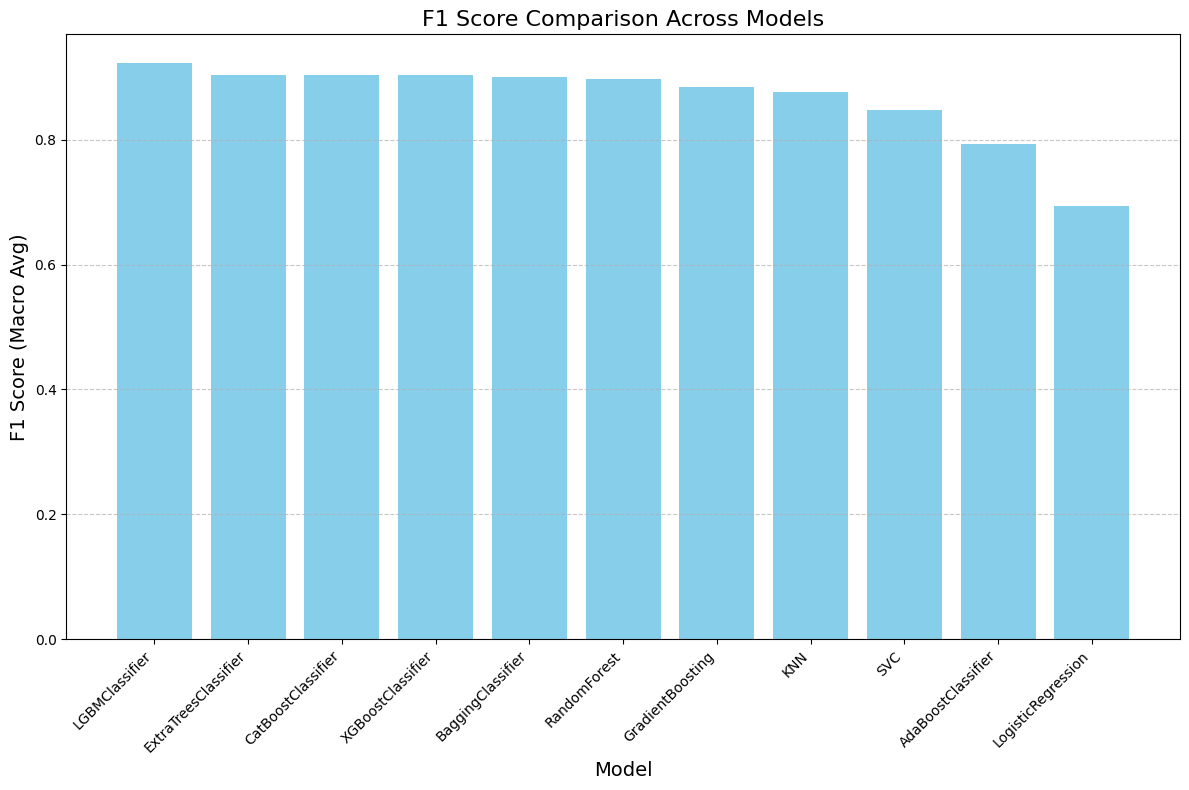

In [36]:
# Extract F1 scores from results and plot
f1_scores = {model_name: results[model_name]['classification_report']['macro avg']['f1-score'] for model_name in results}

# Sort the models by F1 scores for better visualization
sorted_f1_scores = dict(sorted(f1_scores.items(), key=lambda item: item[1], reverse=True))

# Plotting the F1 scores
plt.figure(figsize=(12, 8))
plt.bar(sorted_f1_scores.keys(), sorted_f1_scores.values(), color='skyblue')
plt.xlabel('Model', fontsize=14)
plt.ylabel('F1 Score (Macro Avg)', fontsize=14)
plt.title('F1 Score Comparison Across Models', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
